In [1]:
import numpy as np
import qiskit
import mitiq
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
from qiskit import *
from qiskit import IBMQ

In [2]:
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [3]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

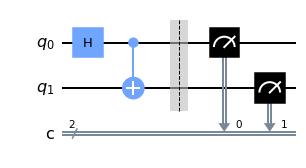

In [4]:
from qiskit.test.mock import FakeVigo

test_circuit = QuantumCircuit(2,2)

#backend = qiskit.Aer.get_backend("qasm_simulator")
backend = FakeVigo()

test_circuit.h(0)
test_circuit.cx(0,1)
test_circuit.barrier()

test_circuit.measure(0,0)
test_circuit.measure(1,1)

job = qiskit.execute(test_circuit,backend,shots=4096)
results = job.result()
counts = results.get_counts()

test_circuit.draw(output='mpl')

In [5]:
counts

{'00': 1856, '11': 1849, '01': 225, '10': 166}

In [6]:
one_qubit_error = .001
two_qubit_error = noise.depolarizing_error(.005,2)

def qiskit_multiqubit_executor(circuit, shots: 2000, state) -> float:
    # Use a depolarizing noise model.
#     noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(
#         depolarizing_error(one_qubit_error, 1),
#         ["u1", "u2", "u3"],
#     )
#     noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])
    
    noise_model = NoiseModel.from_backend(backend)
    
    basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        backend,
        basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    counts = results.get_counts()
    #for x in counts:
    if state not in counts:
        return 0
    else:
        expval = counts[state] / shots
    return expval

In [20]:
qiskit_multiqubit_executor(test_circuit,2000,'11')

0.462

In [7]:
qiskit_multiqubit_executor(Trotter_circuit[1],4096,'01010')

for x in range(0,len(Trotter_circuit)):
    print(qiskit_multiqubit_executor(Trotter_circuit[x],shots = 1000,state = '00010'))

0.02
0.058
0.105
0.147
0.133
0.118
0.078
0.054
0.031
0.031
0.036
0.026
0.025
0.029
0.025
0.034
0.043
0.035
0.043
0.042


In [8]:
from functools import partial

qiskit_executor_01010 = partial(qiskit_multiqubit_executor, shots = 2096, state = '01010')

print(qiskit_multiqubit_executor(Trotter_circuit[0],shots = 2096, state = '01010'))
print(mitiq.execute_with_zne(Trotter_circuit[0],qiskit_executor_01010))

0.8311068702290076
0.8306297709923648


In [9]:
def zne_prob(input_shots, input_state,t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, state = input_state)
    return mitiq.execute_with_zne(Trotter_circuit[t],temp)

In [10]:
zne_prob(1000,'10000',2)

0.019000000000000045

In [11]:
def zero_str(num_zeros):
    zero_string = ''
    x = 0
    while x < num_zeros:
        zero_string = zero_string + '0'
        x += 1
    return zero_string

num_qubits = 5

num_bits=2**num_qubits
state_list = []

for x in range(0,num_bits):
    if x <= num_bits + 1:
        compare = len(bin(num_bits)[2:]) - len(bin(x)[2:])
        state_list.append(zero_str(compare-1) + bin(x)[2:])

state_list

['00000',
 '00001',
 '00010',
 '00011',
 '00100',
 '00101',
 '00110',
 '00111',
 '01000',
 '01001',
 '01010',
 '01011',
 '01100',
 '01101',
 '01110',
 '01111',
 '10000',
 '10001',
 '10010',
 '10011',
 '10100',
 '10101',
 '10110',
 '10111',
 '11000',
 '11001',
 '11010',
 '11011',
 '11100',
 '11101',
 '11110',
 '11111']

In [12]:
def zne_prob_list(shots,state):
    prob_list = []
    for x in range(0,len(Trotter_circuit)):
        prob_list.append(zne_prob(shots,state,x))
    return prob_list

state_dict = {}

for x in state_list:
    state_dict.update({x:zne_prob_list(100,x)})

print(state_dict)

{'00000': [0.0, 0.029999999999999832, 0.07999999999999995, 0.10999999999999988, 0.3100000000000001, 0.0999999999999993, 0.31000000000000005, 0.21000000000000021, 0.0899999999999999, 0.1000000000000001, 0.03999999999999994, 0.02999999999999979, -0.020000000000000337, 0.10000000000000007, 0.08999999999999987, 0.10000000000000007, 0.1300000000000001, 0.07999999999999997, 0.19000000000000022, 0.18000000000000022], '00001': [0.0, 0.009999999999999981, -0.020000000000000104, 0.06000000000000008, 0.05000000000000004, 0.1400000000000003, -0.07000000000000037, 0.029999999999999697, 0.10999999999999995, 0.11000000000000013, 0.06999999999999999, 0.12000000000000033, 0.06000000000000006, 0.07000000000000009, 0.13000000000000017, -0.050000000000000405, -0.02000000000000009, -0.060000000000000386, -0.030000000000000308, -0.05000000000000034], '00010': [0.04999999999999995, 0.13000000000000014, 0.18000000000000002, 0.2100000000000001, 0.019999999999999553, 0.01999999999999952, 0.07999999999999999, 0.

In [15]:
state_dict['01010']

[0.8599999999999987,
 0.5199999999999994,
 0.24999999999999922,
 0.1099999999999991,
 0.14999999999999974,
 0.19000000000000017,
 0.09,
 0.03999999999999992,
 -2.003086131649546e-17,
 0.030000000000000034,
 -0.07000000000000027,
 0.039999999999999945,
 0.020000000000000025,
 0.030000000000000034,
 0.02000000000000007,
 -0.020000000000000104,
 0.050000000000000086,
 0.05000000000000004,
 0.030000000000000086,
 0.10000000000000017]

In [14]:
len(state_dict)

32

In [22]:
def qiskit_single_qubit_executor_z_expval(circuit, shots: 2000, state) -> float:
    # Use a depolarizing noise model.
#     noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(
#         depolarizing_error(one_qubit_error, 1),
#         ["u1", "u2", "u3"],
#     )
#     noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])
    
    noise_model = NoiseModel.from_backend(backend)
    
    basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        backend,
        basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    counts = results.get_counts()
    #for x in counts:
    if state not in counts:
        return 0
    else:
        expval = counts[state] / shots
    return expval

qiskit_multiqubit_executor(Trotter_circuit[1],2000,'00000')

0.025

In [23]:
qiskit_multiqubit_executor(test_circuit,2000,'00')

0.447

In [26]:
test_state_list = ['00','01','10','11']

prob_1 = 0

for x in test_state_list:
    if x[-1] == '1':
        prob_1 += qiskit_multiqubit_executor(test_circuit,2000,x)

prob_1

0.5125000000000001

In [27]:
qiskit_multiqubit_executor(test_circuit,2000,'01') + qiskit_multiqubit_executor(test_circuit,2000,'11')

0.5125000000000001